## Yuvoh - Data Scientist Challenge

### Modeling and Prediction

Boosting Gradient Regressor is used to predict price. GridSearch is utilised to find the optimal hyper-parameters. 

The original data set is divided into Train set (70%) and Test set (30%). The Train set is subdivided into train set and validation set (30%) for tunning the hyper parameters.

Log is applied to price to reduce the skewedness

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib._color_data as mcd
import numpy as np

from sklearn.metrics import mean_squared_error

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.ensemble.gradient_boosting import GradientBoostingRegressor


import warnings
warnings.filterwarnings("ignore")

In [2]:
X = pd.read_csv('train.csv')
y = pd.read_csv('target.csv',header=None)

In [3]:
#remove id
X.drop('id', axis=1, inplace=True)

#Feature scaling
#Apply log to price
y = np.log(y)
X['cleaning_fee'] = X['cleaning_fee'].apply(lambda x: 0.0 if x < 1.0 else np.log(x))
X['security_deposit'] = X['security_deposit'].apply(lambda x: 0.0 if x < 1.0 else np.log(x))
X['extra_people'] = X['extra_people'].apply(lambda x: 0.0 if x < 1.0 else np.log(x))

#### Tuning the hyper-parameters

In [4]:
#Tuning parameters with GridSearch
#data set parttion into train, val and test sets
#Take 70% of the data as training data, and the remainder 30% as test dataset
X_t, X_test, y_t, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_t, y_t, test_size=0.3, random_state=42)

#Set the set of parameter for Grid search
param_options = [
    { 'n_estimators': [100,500],
      'max_depth': [3,5],
      'min_samples_split' : [2,4]
    }
]

#Grid search return the optimal regressor based on different parameters
gboost = GradientBoostingRegressor(random_state = 42,max_features = 'sqrt',loss='lad')
grid = GridSearchCV(gboost, cv=3, n_jobs=2, param_grid=param_options, scoring='neg_mean_squared_error')

#create the model using training set
grid.fit(X_train,y_train)

#predict using the validation set
y_pred = grid.predict(X_val)
print("Best parameters: ", grid.best_params_)
#grid.cv_results_ 

mse = mean_squared_error(y_val, y_pred)
print("MSE: %.4f" % mse)
print("SMSE: %.4f" % np.sqrt(mse))#square root

Best parameters:  {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 500}
MSE: 0.1439
SMSE: 0.3793


The Mean Squared Error is low meaning that we get a good model.

Below plot for assessing how well the model perdict the price in validation dataset compared with true values. Histogram of predicted prices. The scatter plot predited vs true values shows that points are clusterd around the line hoever, some points are isoleted on the rigth.

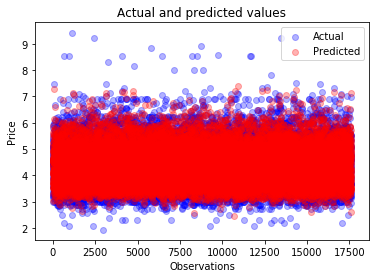

In [5]:
_, ax = plt.subplots()

ax.scatter(x = range(0, y_val.size), y=y_val, c = 'blue', label = 'Actual', alpha = 0.3)
ax.scatter(x = range(0, y_pred.size), y=y_pred, c = 'red', label = 'Predicted', alpha = 0.3)

plt.title('Actual and predicted values')
plt.xlabel('Observations')
plt.ylabel('Price')
plt.legend()
plt.show()

Text(0, 0.5, 'Frequency')

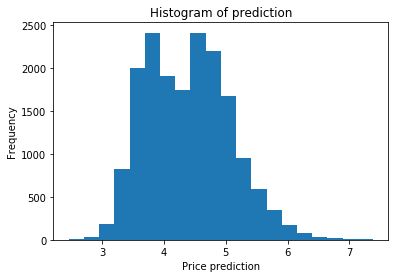

In [6]:
#Visualize a histogram of predicted prices

#diff = y_val.values.T- y_pred
plt.hist(y_pred,bins = 20)
plt.title('Histogram of prediction')
plt.xlabel('Price prediction')
plt.ylabel('Frequency')

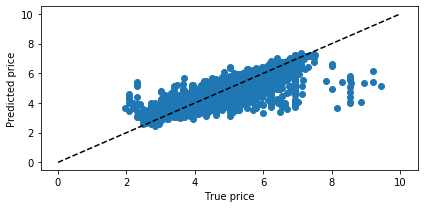

In [17]:
plt.figure(figsize=(6, 3))
plt.scatter(y_val, y_pred)
plt.plot([0, 10], [0, 10], '--k')
plt.axis('tight')
plt.xlabel('True price')
plt.ylabel('Predicted price')
plt.tight_layout()

#### Price Prediction

Gradient Boosting Regressor is run with optimal parameters and entire train set. Test set is used for prediction and assess generalisation. 

The prediction improved slightly (Mean Squared Error is slightly smaller). So that the model is able to generalise well. 

Below plot for assessing how well the model perdict the price in validation dataset compared with true values. Histogram of predicted prices. The scatter plot predited vs true values shows that points are clusterd around the line. But the distance between isolated points are bigger that in the validation case. 

In [1]:
#Run gboost with optimal parameters on the entire X_train
reg_gb = GradientBoostingRegressor(**grid.best_params_)
#Predict price
reg_gb.fit(X_t,y_t)
pred=reg_gb.predict(X_test)
                                   
mse = mean_squared_error(y_test, pred)
print("MSE: %.4f" % mse)
print("SMSE: %.4f" % np.sqrt(mse))#square root

NameError: name 'GradientBoostingRegressor' is not defined

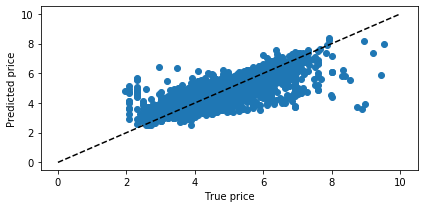

In [18]:
plt.figure(figsize=(6, 3))
plt.scatter(y_test, pred)
plt.plot([0, 10], [0, 10], '--k')
plt.axis('tight')
plt.xlabel('True price')
plt.ylabel('Predicted price')
plt.tight_layout()

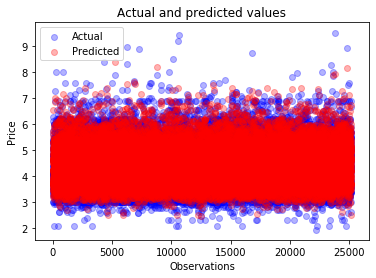

In [10]:
_, ax = plt.subplots()

ax.scatter(x = range(0, y_test.size), y=y_test, c = 'blue', label = 'Actual', alpha = 0.3)
ax.scatter(x = range(0, pred.size), y=pred, c = 'red', label = 'Predicted', alpha = 0.3)

plt.title('Actual and predicted values')
plt.xlabel('Observations')
plt.ylabel('Price')
plt.legend()
plt.show()

Text(0, 0.5, 'Frequency')

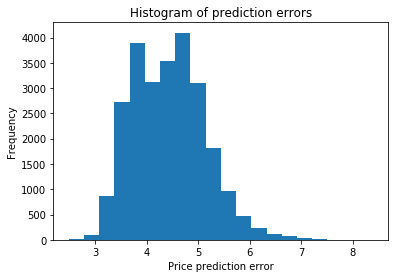

In [13]:
#diff = y_test.values.T - pred
#diff.hist(bins = 40)
plt.hist(pred,bins = 20)
plt.title('Histogram of prediction errors')
plt.xlabel('Price prediction error')
plt.ylabel('Frequency')

#### Feature Importance

The most important feature is Room Type. Following the Number of bathrooms, Accomodates and Cleaning fee in that order.

The location (latitude and longitude) variables have some relevance as well, being the neibourhood_inner_central (central London) the area that most influence the price.

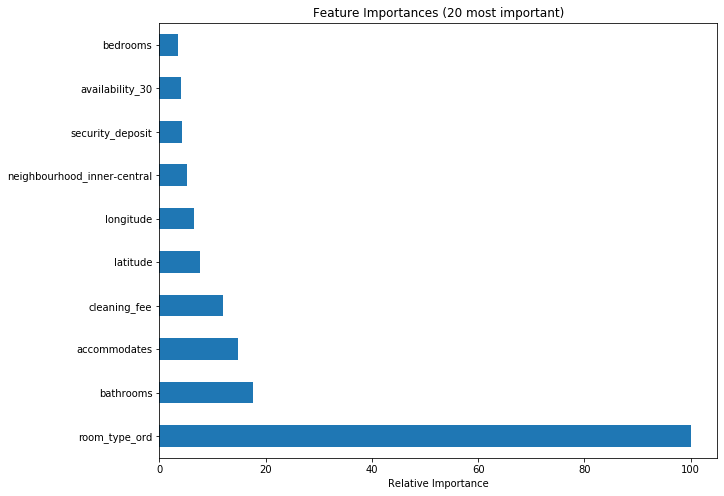

In [33]:
feature_importance = reg_gb.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)

plt.figure(figsize = (10,8))
plt.title('Feature Importances (10 top)')
pd.Series(feature_importance[sorted_idx], index=X_t.columns[sorted_idx]).nlargest(10).plot(kind='barh')#.nlargest(4)
plt.xlabel('Relative Importance')
plt.show()


### Futher works

It is a good practice to use several algorithms and compare performance. Choosing the best model via GridSearch as following. 

Note: Just showing the pipeline. Did not run it as take too much time.

In [ ]:
#Tuning parameters using gridSearch
#Create the pipeline
svr = SVR(gamma='scale')#or 0.1
gboost = GradientBoostingRegressor(random_state = 42,max_features = 'sqrt',loss='lad')
pipe = Pipeline( steps=[('svr', svr ), ('gboost', gboost) ] )

#Set the set of parameter for Grid search
param_options = [
    {   'C': [0.1, 1.0],
        'kernel': ['linear','rbf'],
        'epsilon' : [0.1,0.01]
    },
    
    { 'gb__n_estimators': [100,500],
      'gb__max_depth': [3,5],
      'gb__min_samples_split' : [2,4]
    }
]

#Grid search return the optimal classifier based on different parameters
grid = GridSearchCV(pipe, cv=3, n_jobs=2, param_grid=param_options,scoring='neg_mean_squared_error')
#create the model using training set
grid.fit(X_train,y_train)

#predict using the validation set
y_pred = grid.predict(X_val)

mse = mean_squared_error(y_val, y_pred)
print("MSE: %.4f" % mse)
print("SMSE: %.4f" % np.sqrt(mse))#square root

#### Other things to do
* Remove outliers for 'price', 'security_deposit' and 'cleaning_fee'
* Split 'amenities' into individual strings and use and encoding method such as mean encoding, hashing encoding or 
* The free text variables allow the hoster to describe their listing.  Doing topic modeling (NLP) in these variables might give some insights in what makes the hoster decide the price.